# **End-to-end ML PySpark Tutorial**

In [81]:
# general
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import SparkSession

# EDA and pre-processing
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import StandardScaler, VectorAssembler

# clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# visualisation
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

## **Step 1: Create a SparkSession**

A SparkSession is an entry point into all functionality in Spark, and is required if you want to build a dataframe in PySpark.

In the code below, we:
- built a spark session
- gave it a name
- cached the data in off-heap memory to avoid storing it directly on disk
- manally specified the amount of memory

In [3]:
spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled", "true").config("spark.memory.offHeap.size", "10g").getOrCreate()

## **Step 2: Create a DataFrame**

Read in the downloaded data. Note that we define an escape character to avoid commas in the csv file when parsing.

View the head of the dataframe with `show()`.

In [48]:
df = spark.read.csv('online_retail.csv', header=True, escape="\"")
df.show(10, 0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |22752    |SET 7 BABUSHKA NESTING BOXES       |2       |12/1/1

## **Step 3: Exploratory Data Analysis**

In [52]:
# count the number of rows
df.count()

541909

In [53]:
# how many unique customers are present?
df.select('CustomerID').distinct().count()

4373

In [54]:
# what country do most purchases come from?
# df.groupby('Country').agg(countDistinct('CustomerID').alias('country_count')).show()
# in descending order
df.groupby('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [55]:
# when was the most recent purchase made by a customer?
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

# need to convert InvoiceDate into a timestamp format
df = df.withColumn('date', to_timestamp("InvoiceDate", 'dd/MM/yy HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-10 17:19:00|
+-------------------+



In [56]:
# when was the oldest purchase made by a customer
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-01-12 08:26:00|
+-------------------+



The dates above indicate that there is around two years of purchase data in the file.

## **Step 4: Data Pre-processing**

In [61]:
df.show(5, 0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|2010-01-12 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2010-01-12 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|2010-01-12 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2010-01-12 08:26:00|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEA

We will be creating multiple customer segments based on each user's purchase behaviour. However, the variables are in a format not easily ingested into a customer segmentation model and individually do not tell us much about customer purchase behaviour.

We will be deriving three more informative variables:
- Recency: How recently has each customer made a purchase?
- Frequency: How often has each customer made a purchase?
- Monetary Value: How much money do they spend on average when making a purchase?

In [65]:
# assign a recency score to each purchase
df = df.withColumn("from_date", lit("12/1/10 8:26"))
df = df.withColumn('from_date', to_timestamp("from_date", 'dd/MM/yy HH:mm'))

df2 = df.withColumn('from_date', to_timestamp(col('from_date'))).withColumn('recency', col("date").cast("long") - col('from_date').cast("long"))

# select the most recent purchase for each customer
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')), on='recency', how='leftsemi')

# view the first few rows of the new dataframe
df2.show(5, 0)

+-------+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |12/1/10 9:53|6.45     |18074     |United Kingdom|2010-01-12 09:53:00|2010-01-12 08:26:00|
|5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |12/1/10 9:53|0.65     |18074     |United Kingdom|2010-01-12 09:53:00|2010-01-12 08:26:00|
|5220   |536384   |22464    |HANGING METAL HEART LANTERN        |12      |12/1/10 9:53|1.65     |18074     |United Kingdom|2010-01-12 09:53:00|2010-01-12 08:26:00|
|5220   |536384 

In [67]:
# view the schema (equivalent to info() function in Pandas)
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [68]:
# assign a frequency to each customer
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))
df_freq.show(5, 0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15574     |121      |
|13610     |20       |
|16320     |47       |
|13282     |1        |
+----------+---------+
only showing top 5 rows



In [69]:
# join the dataframes together
df3 = df2.join(df_freq, on='CustomerID', how='inner')
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [70]:
# calculate the total amount spent by each customer
# step 1: find the total amount spent in each purchase
m_val = df3.withColumn('TotalAmount', col('Quantity') * col('UnitPrice'))
# step 2: find the total amount spent by each customer
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

# merge this data with the other variables
final_df = m_val.join(df3, on='CustomerID', how='inner')
# select only wanted columns and drop duplicate rows
final_df = final_df.select(['recency', 'frequency', 'monetary_value', 'CustomerID']).distinct()
final_df.show(5, 0)

+--------+---------+------------------+----------+
|recency |frequency|monetary_value    |CustomerID|
+--------+---------+------------------+----------+
|5580    |14       |226.14            |16250     |
|2704800 |121      |375.65            |15574     |
|54453660|20       |110.55000000000001|13610     |
|54543900|47       |852.6800000000002 |16320     |
|59799420|1        |-2.55             |13282     |
+--------+---------+------------------+----------+
only showing top 5 rows



**Standardisation**

Standardise the data to ensure that all variables are on the same scale.

In [72]:
assemble = VectorAssembler(inputCols=['recency', 'frequency', 'monetary_value'], outputCol='features')
assembled_data = assemble.transform(final_df)

scale = StandardScaler(inputCol='features', outputCol='standardised')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)

# view the standardised feature vector
data_scale_output.select('standardised').show(2, truncate=False)

+---------------------------------------------------------------+
|standardised                                                   |
+---------------------------------------------------------------+
|[4.5655434635006486E-4,0.45450804304970194,0.07578116853200018]|
|[0.22130612831678412,3.928248086358138,0.1258830634078264]     |
+---------------------------------------------------------------+
only showing top 2 rows



## **Step 5: Building the ML model**

In this step, we will be building the k-means clustering model using PySpark's ML API.

In [78]:
# identify the number of clusters using the elbow method
cost = np.zeros(10)
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardised', metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2, 10):
    KMeans_algo = KMeans(featuresCol='standardised', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

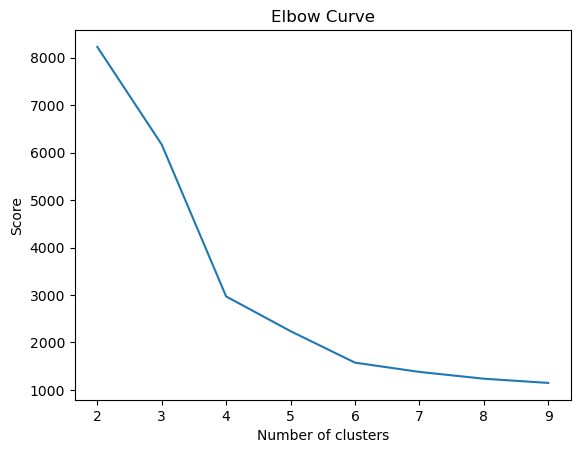

In [80]:
# view the results in a line chart
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2, 10)
df_cost.insert(0, 'cluster', new_col)

pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

The plot above indicates that there is are inflection points at 4 and 6 clusters. We will try both to observe which results in a better segmentation.

**4 segment model**

In [82]:
num_clus = 4

KMeans_algo = KMeans(featuresCol='standardised', k=num_clus)
KMeans_fit = KMeans_algo.fit(data_scale_output)

# assign each customer to a cluster
preds = KMeans_fit.transform(data_scale_output)
preds.show(5, 0)

+--------+---------+------------------+----------+------------------------------------+---------------------------------------------------------------+----------+
|recency |frequency|monetary_value    |CustomerID|features                            |standardised                                                   |prediction|
+--------+---------+------------------+----------+------------------------------------+---------------------------------------------------------------+----------+
|5580    |14       |226.14            |16250     |[5580.0,14.0,226.14]                |[4.5655434635006486E-4,0.45450804304970194,0.07578116853200018]|3         |
|2704800 |121      |375.65            |15574     |[2704800.0,121.0,375.65]            |[0.22130612831678412,3.928248086358138,0.1258830634078264]     |0         |
|54453660|20       |110.55000000000001|13610     |[5.445366E7,20.0,110.55000000000001]|[4.455386227180766,0.649297204356717,0.03704611382865756]      |1         |
|54543900|47       |85

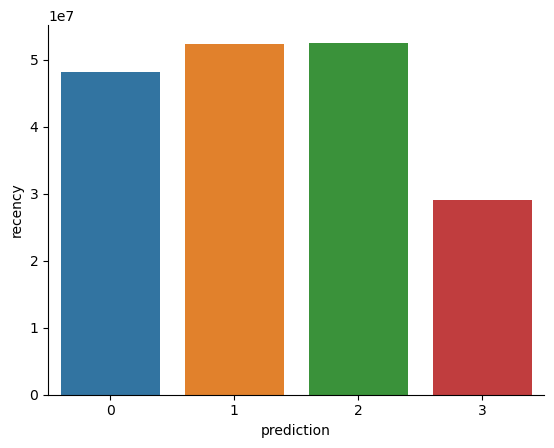

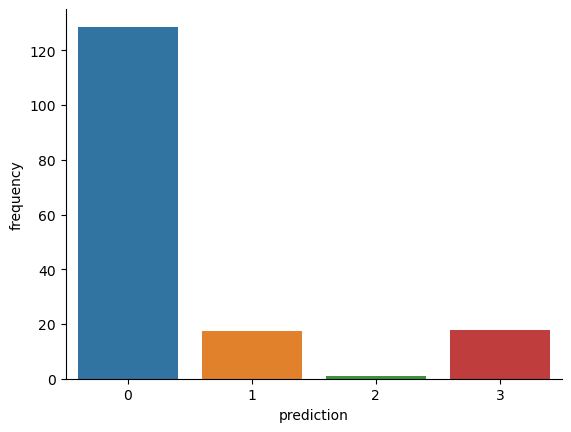

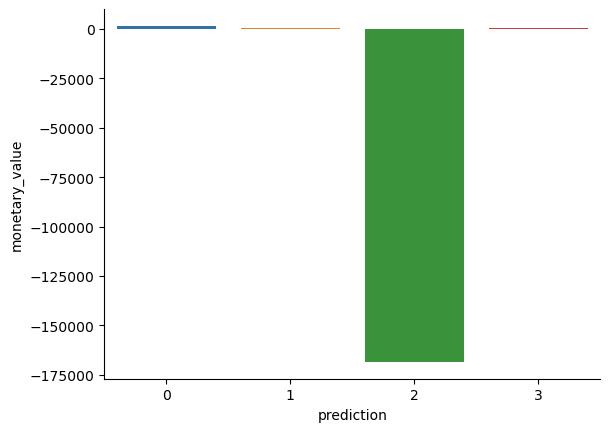

In [84]:
df_viz = preds.select('recency', 'frequency', 'monetary_value', 'prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

features_list = ['recency', 'frequency', 'monetary_value']

for feat in features_list:
    sns.barplot(x='prediction', y=str(feat), data=avg_df)
    sns.despine()
    plt.show()

In [86]:
avg_df

,prediction,recency,frequency,monetary_value
0,0,4.821621e+07,128.653595,1545.708301
1,1,5.229763e+07,17.565426,337.123105
2,2,5.253486e+07,1.000000,-168469.600000
3,3,2.898847e+07,17.636364,283.464790


Here is an overview of the characteristics displayed by customers in each cluster:
- Cluster 0: Customers in this segment display high recency and frequency, and how monetary value. They are regular customers that possibly tend to buy higher-value items or make bulk purchases.
- Cluster 1: Customers in this segment display high recency, low frequency and medium monetary value. These may be newer customers who have just started doing business with the company.
- Cluster 2: Customers in this segment display high recency, but very low frequency and negative monetary value. These could be new customers that have been unhappy with the product received and returned their purchase. These customers are highly likely to stop doing business with the company.
- Cluster 3: Customers in this segment display medium recency, low frequency and medium monetary value. These customers have been seen on the platform in the recent past, but don't visit often.

**6 segment model**

Let's see if more segments provide a better segmentation.

In [91]:
num_clus = 6

KMeans_algo = KMeans(featuresCol='standardised', k=num_clus)
KMeans_fit = KMeans_algo.fit(data_scale_output)

# assign each customer to a cluster
preds = KMeans_fit.transform(data_scale_output)
preds.show(5, 0)

+--------+---------+------------------+----------+------------------------------------+---------------------------------------------------------------+----------+
|recency |frequency|monetary_value    |CustomerID|features                            |standardised                                                   |prediction|
+--------+---------+------------------+----------+------------------------------------+---------------------------------------------------------------+----------+
|5580    |14       |226.14            |16250     |[5580.0,14.0,226.14]                |[4.5655434635006486E-4,0.45450804304970194,0.07578116853200018]|5         |
|2704800 |121      |375.65            |15574     |[2704800.0,121.0,375.65]            |[0.22130612831678412,3.928248086358138,0.1258830634078264]     |5         |
|54453660|20       |110.55000000000001|13610     |[5.445366E7,20.0,110.55000000000001]|[4.455386227180766,0.649297204356717,0.03704611382865756]      |1         |
|54543900|47       |85

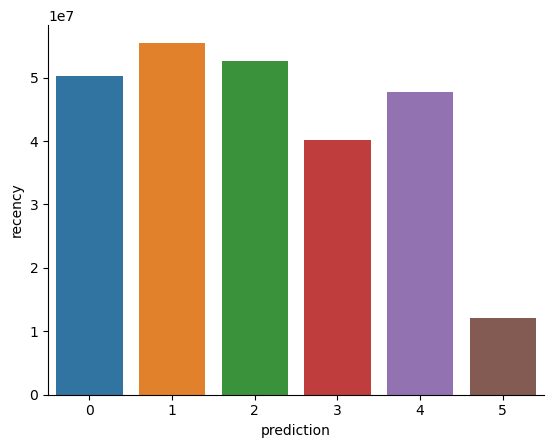

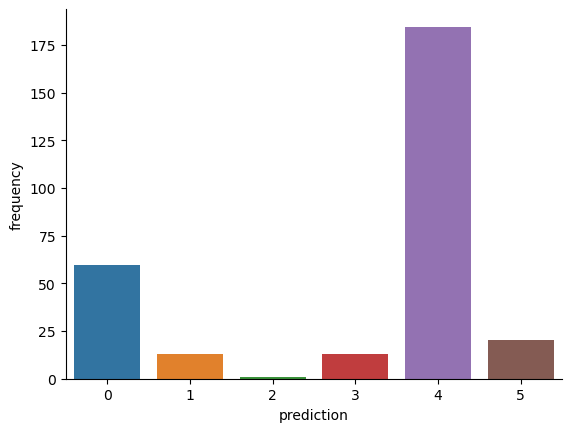

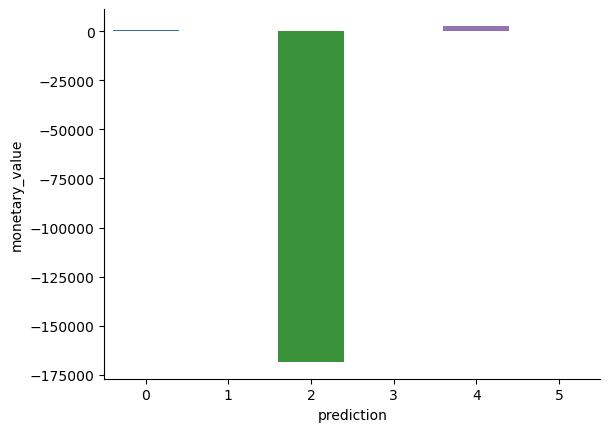

In [92]:
df_viz = preds.select('recency', 'frequency', 'monetary_value', 'prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

features_list = ['recency', 'frequency', 'monetary_value']

for feat in features_list:
    sns.barplot(x='prediction', y=str(feat), data=avg_df)
    sns.despine()
    plt.show()

In [93]:
avg_df

,prediction,recency,frequency,monetary_value
0,0,5.020494e+07,59.776498,697.270461
1,1,5.549455e+07,12.995521,306.014408
2,2,5.253486e+07,1.000000,-168469.600000
3,3,4.020435e+07,13.165785,256.269277
4,4,4.771105e+07,184.516129,2678.193548
5,5,1.202362e+07,20.168367,256.654592


Here is an overview of the characteristics displayed by customers in each cluster:
- Cluster 0: Customers in this segment display high recency and medium frequency and monetary value. They have been seen very recently on the platform, but don't always make purchases.
- Cluster 1: Customers in this segment display high recency, but low freqency and low monetary value. They also have been seen very recently, but rarely make purchases and these tend to be of cheaper-value items. 
- Cluster 2: Customers in this segment display high recency, but very low frequency and negative monetary value. These could be new customers who were unhappy with their product and returned it. These customers are highly likely to stop doing business with the company.
- Cluster 3: Customers in this segment display lower recency, low frequency and low monetary value. They visit the platform less frequently and when they do, make cheaper purchases. These are customers less likely to make purchases in the future.
- Cluster 4: Customers in this segment display high recency, very high frequency and high monetary value. These are loyal and frequent customers that make high-value or bulk purchases.
- Cluster 5: Customers in this segment display low recency, medium frequency and medium monetary value. These are customers that haven't visited the platform recently, but do visit fairly often and may possibly make more purchases in the future.